In [ ]:
# 📥 Download GloVe 6B zip file (100D vectors included)
!wget http://nlp.stanford.edu/data/glove.6B.zip

# 📦 Unzip it
!unzip -q glove.6B.zip

# 📌 Confirm the file is ready
!ls -lh glove.6B.100d.txt


--2025-07-15 18:09:50--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-07-15 18:09:50--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-07-15 18:09:50--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# STEP 1: Install + Import Everything Cleanly
!pip install nltk --quiet

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# STEP 2: Download stopwords from NLTK
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# STEP 3: Load and Sample Sentiment140 Dataset
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv.zip', encoding='latin-1', header=None)
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = df[['target', 'text']]
df['target'] = df['target'].apply(lambda x: 1 if x == 4 else 0)
df = df.sample(300000, random_state=42)  # Using subset for faster training


In [ ]:
# STEP 4: Clean Tweet Text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = " ".join(word for word in text.split() if word not in stop_words)
    return text

df['clean_text'] = df['text'].apply(clean_text)


In [ ]:
# STEP 5: Tokenize and Pad Sequences
MAX_VOCAB_SIZE = 20000
MAX_SEQ_LENGTH = 100
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
word_index = tokenizer.word_index

X = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH)
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# STEP 6: Load GloVe Embeddings
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs

embedding_matrix = np.zeros((MAX_VOCAB_SIZE, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [ ]:
# STEP 7: Build the CNN + BiLSTM Model
model = Sequential()
model.add(Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix],
                    input_length=MAX_SEQ_LENGTH, trainable=True))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 2,000,000 (7.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# STEP 8: Train the Model
early_stop = EarlyStopping(monitor='val_loss', patience=3)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=128,
    callbacks=[early_stop, lr_scheduler]
)


Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 795s 525ms/step - accuracy: 0.7204 - loss: 0.5418 - val_accuracy: 0.7727 - val_loss: 0.4775 - learning_rate: 0.0010
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 800s 523ms/step - accuracy: 0.7981 - loss: 0.4382 - val_accuracy: 0.7770 - val_loss: 0.4660 - learning_rate: 0.0010
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 825s 539ms/step - accuracy: 0.8226 - loss: 0.3951 - val_accuracy: 0.7727 - val_loss: 0.4949 - learning_rate: 0.0010
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 869s 544ms/step - accuracy: 0.8475 - loss: 0.3467 - val_accuracy: 0.7660 - val_loss: 0.5356 - learning_rate: 0.0010
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 838s 528ms/step - accuracy: 0.8858 - loss: 0.2692 - val_accuracy: 0.7583 - val_loss: 0.6308 - learning_rate: 5.0000e-04


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 43ms/step - accuracy: 0.7622 - loss: 0.6254

✅ Final Test Accuracy: 0.7605
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 87s 46ms/step

📊 Classification Report:
              precision    recall  f1-score   support

    Negative       0.76      0.76      0.76     29850
    Positive       0.76      0.76      0.76     30150

    accuracy                           0.76     60000
   macro avg       0.76      0.76      0.76     60000
weighted avg       0.76      0.76      0.76     60000



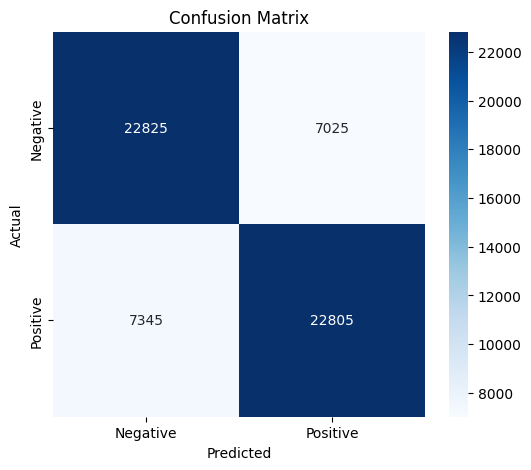

In [ ]:
# STEP 9: Evaluate and Show Results
loss, acc = model.evaluate(X_test, y_test)
print(f"\n✅ Final Test Accuracy: {acc:.4f}")

y_pred = (model.predict(X_test) > 0.5).astype("int32").flatten()

# Print classification report
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
# STEP 10: Individual Metrics
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")


Accuracy:  0.7605
Precision: 0.7645
Recall:    0.7564
F1 Score:  0.7604


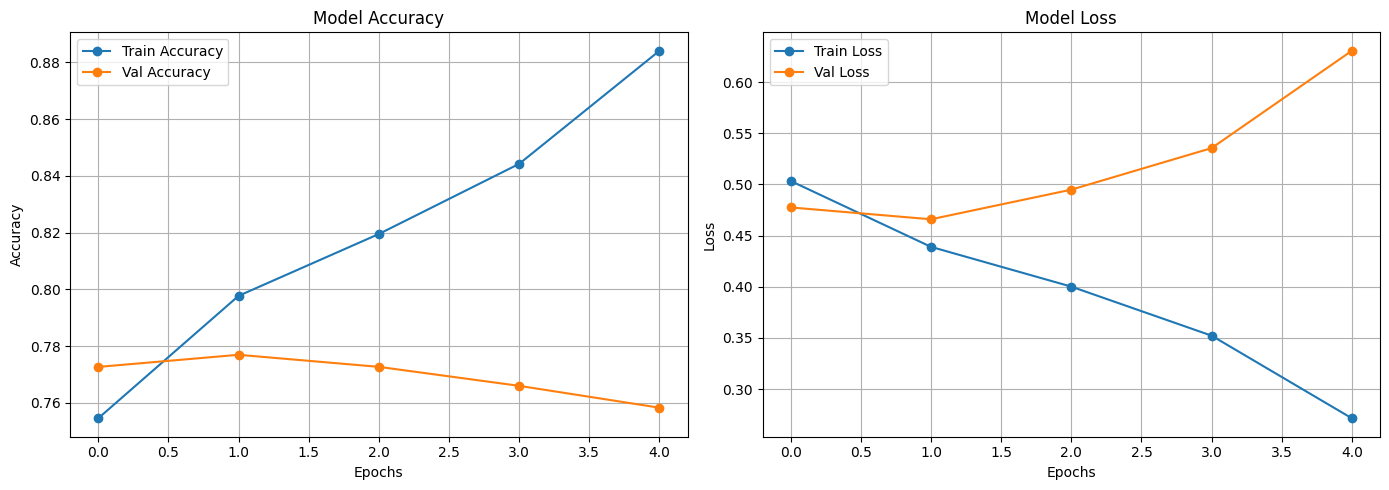

In [ ]:
# 📈 Training vs Validation Accuracy & Loss
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# 📋 Classification Report in Table Format
report = classification_report(y_test, y_pred, target_names=["Negative", "Positive"], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Show only important columns
report_df[['precision', 'recall', 'f1-score']].round(3)


,precision,recall,f1-score
Negative,0.757,0.765,0.761
Positive,0.764,0.756,0.760
accuracy,0.760,0.760,0.760
macro avg,0.761,0.761,0.760
weighted avg,0.761,0.760,0.760
